In [46]:
#IMPORT KERAS
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
print(keras.backend.backend())

tensorflow


In [47]:
#IMPORT THE PACKAGES
import cv2,sklearn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras import layers, losses, callbacks, activations, regularizers, metrics, applications, optimizers

In [48]:
#LOAD THE DATA
data = os.path.join('dataset','Concrete Crack Images for Classification')
BATCH_SIZE = 10
IMG_SIZE = (160, 160)
train_d, val_d = keras.utils.image_dataset_from_directory(data,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE,
                                                          validation_split=0.3,
                                                          subset='both',
                                                          seed=42)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.
Using 12000 files for validation.


['Negative', 'Positive']


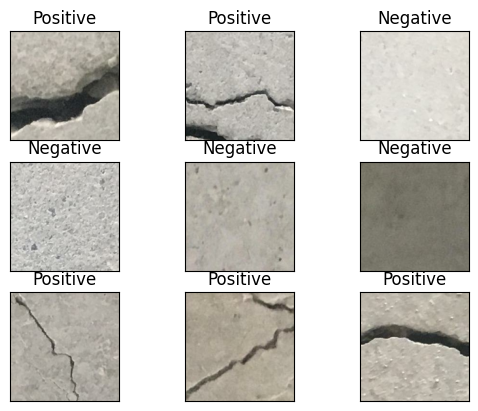

In [49]:
#INSPECT DATA
class_names = train_d.class_names
print(class_names)
batch_1 = train_d.take(1)
for feature, label in batch_1:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    plt.show()

In [50]:
#Convert the val dataset back to PrefetchDataset
val_d = val_d.prefetch(buffer_size=tf.data.AUTOTUNE)

In [51]:
#Create a sequential model for augmentation
data_aug = keras.Sequential()
data_aug.add(layers.RandomFlip())
data_aug.add(layers.RandomRotation(factor=0.2))
# Create the preprocessing layer based on the pretrained model that we will use
preprocess_input = applications.mobilenet_v2.preprocess_input

In [52]:
# apply transfer learning using pretrained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# freeze the feature extractor to make sure we only train the classifier
base_model.trainable = False
base_model.summary()
# construct classifier
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names), activation='softmax')

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

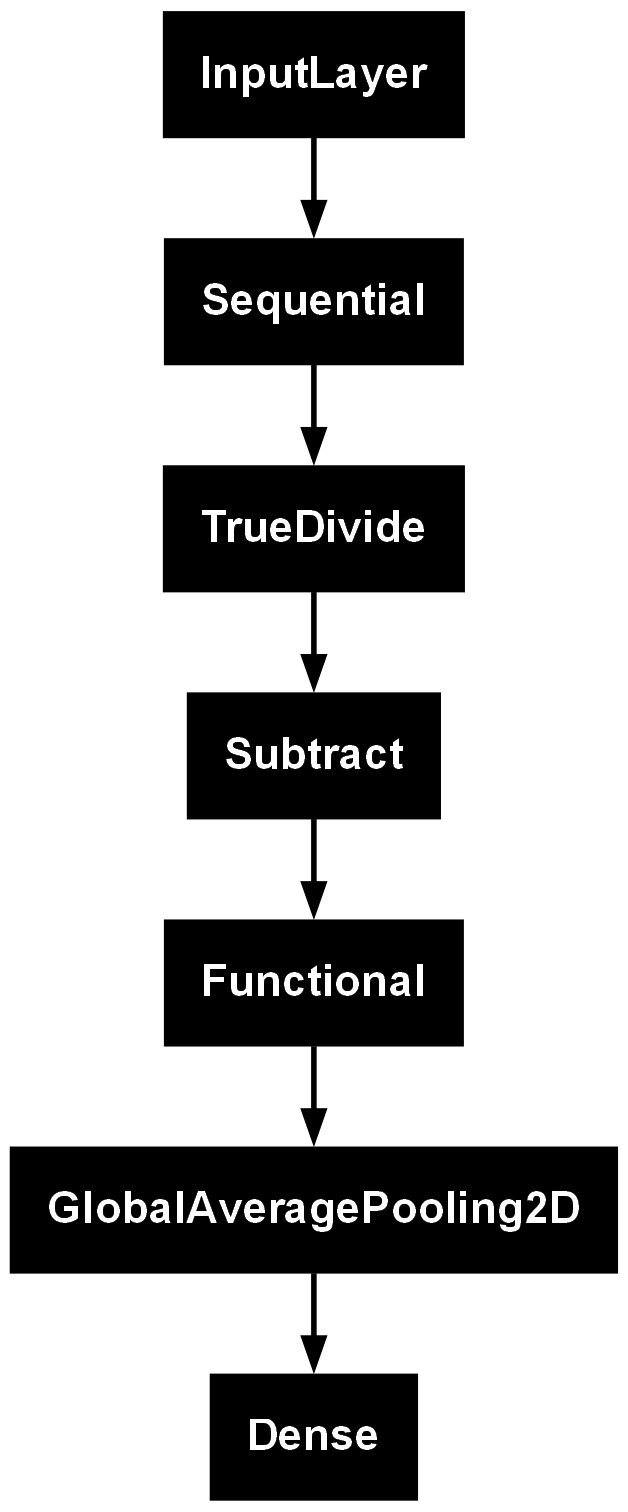

In [53]:
# use functional api to connect all layers
inputs = keras.Input(shape=IMG_SHAPE)
# augmentation layers
x = data_aug(inputs)
# preprocessing layer
x = preprocess_input(x)
# feature extractor
x = base_model(x)
# classifier
x = global_avg(x)
outputs = output_layer(x)
# create model
model = keras.Model(inputs = inputs, outputs= outputs)
model.summary()
keras.utils.plot_model(model=model)

In [54]:
# compile model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer= optimizer, loss=loss, metrics=['accuracy'])

In [55]:
# train model and log to tensorboard
log_path = os.path.join(os.getcwd(),"logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
ts = callbacks.TensorBoard(log_dir=log_path)
stop = keras.callbacks.EarlyStopping(patience=3,verbose=1)
history = model.fit(train_d, validation_data=val_d, epochs=15,callbacks=[ts,stop])

Epoch 1/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 209s 73ms/step - accuracy: 0.9531 - loss: 0.1212 - val_accuracy: 0.9973 - val_loss: 0.0095
Epoch 2/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 192s 68ms/step - accuracy: 0.9978 - loss: 0.0080 - val_accuracy: 0.9978 - val_loss: 0.0076
Epoch 3/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 192s 69ms/step - accuracy: 0.9981 - loss: 0.0068 - val_accuracy: 0.9983 - val_loss: 0.0062
Epoch 4/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 194s 69ms/step - accuracy: 0.9979 - loss: 0.0054 - val_accuracy: 0.9984 - val_loss: 0.0070
Epoch 5/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 193s 69ms/step - accuracy: 0.9986 - loss: 0.0049 - val_accuracy: 0.9981 - val_loss: 0.0069
Epoch 6/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 201s 72ms/step - accuracy: 0.9984 - loss: 0.0046 - val_accuracy: 0.9984 - val_loss: 0.0057
Epoch 7/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 206s 74ms/step - accuracy: 0.9988 - loss: 0.0042 - val_accuracy: 0.9984 - val_loss: 0.0053
Epoch 8/15
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 209s 75ms/step - accuracy: 

In [56]:
# Evaluate the model after the training
model.evaluate(val_d)


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 76s 63ms/step - accuracy: 0.9984 - loss: 0.0064


[0.005373761523514986, 0.9985833168029785]

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Graph')
plt.legend(['Training loss','Validation loss'])
plt.show()

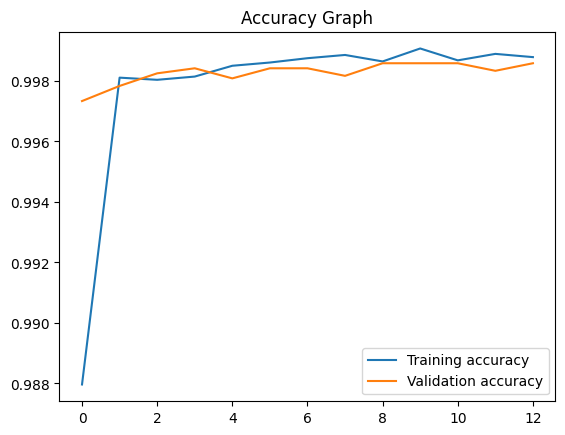

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Graph')
plt.legend(['Training accuracy','Validation accuracy'])
plt.show()

In [59]:
#save keras model
model_filepath = os.path.join(os.getcwd(),'models','model.keras')
model.save(model_filepath, overwrite=True, zipped=None)

In [ ]:
'''
#The function below can be use to load the model
def load_model(filepath):
    import keras  
    model = keras.saving.load_model(filepath, custom_objects=None, compile=True, safe_mode=True)
    return model
'''